## Lab 3: RADIO INTERFEROMETRY AT X BAND

In [4]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.time import Time
import time
import get_multimeter

### Week One
#### Rotation matrix for timing locations
Each group uses rotation matrices to calculate when objects of interest are up. 

#### Solar Fringes
Observe the Sun for a short time to confirm that it sees fringes. 

#### Observe a point source
Each group does a horizon-to-horizon observation of a point source, which requires writing an observing script to run automatically. 

#### Power spectra
Each person calculates Fourier power spectra of the Sun data and also the point-source data.

#### Compare to expected fringe frequencies
Calculate the range of expected local fringe frequencies (equation 14) and compares the observed spectra with these expectations. Be ready for show and tell!

### 8.1. Getting the Data
FIRST WEEK: Before doing the weak sources in the Table, do the Sun for a much shorter time, say an hour. This will give you confidence that the system works (or so we hope). There should be an easily-recognizable signal that you can look at visually, think about, and derive the
approximate declination with pencil and paper. Then later you can write software to do the same, and make sure you get the right answer. Also, during this first week, do the horizon-to-horizon track of one of the sources from the Table.

### 8.2. The Fringe

In [2]:
ugradio.timing.julian_date??

In [4]:
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])


In [5]:
np.delete(arr, 1, 0)

array([[ 1,  2,  3,  4],
       [ 9, 10, 11, 12]])

In [35]:
volts = [np.load(f) for f in glob.glob('/home/cgould/ugradio/ugradio-scout-master/*volts.npy')]
times = [np.load(f) for f in glob.glob('/home/cgould/ugradio/ugradio-scout-master/*unitimes.npy')]

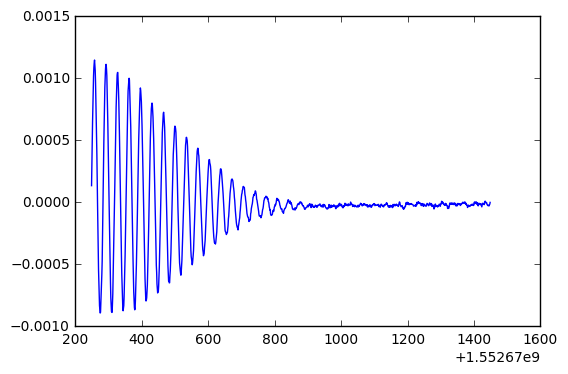

In [42]:
plt.plot(times[0], volts[0])
plt.show()

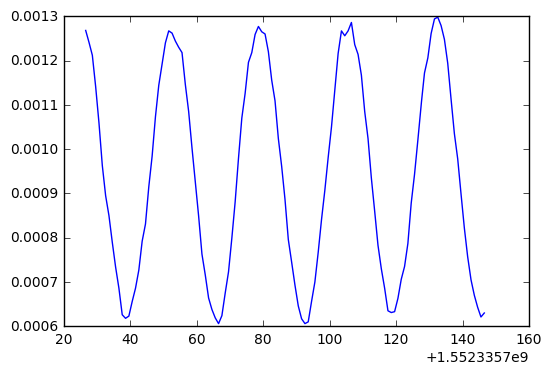

In [47]:
plt.plot(times[1], volts[1])
plt.show()

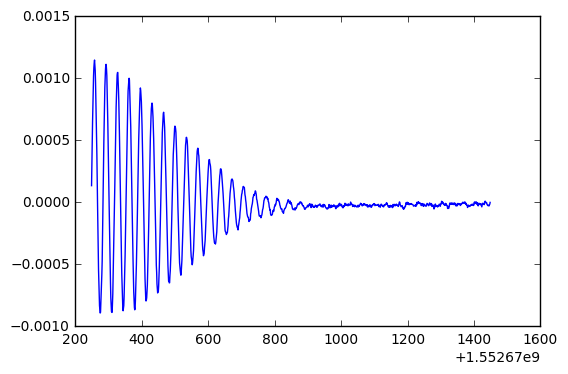

In [48]:
plt.plot(times[2], volts[2])
plt.show()

In [44]:
times[0][10]

1552670258.546824

# Getting Data from the Multimeter

HP_Multimeter():

    '''Client for reading from the HP 3478A Multimeter used to integrate
    baseband voltages in the UGRadio Interferometer.  Sends commands over
    the network to a microcontroller that translates commands to the GPIB
    bus on the back of the multimeter.'''

start_recording(self, dt, tries=10):

     '''Initiate continuous reading from multimeter every dt seconds.

read_voltage(self, bufsize=1024, return_time=False):
        '''Take a one-time reading from the multimeter.

        Parameters
        ----------
        bufsize     : integer, size of receiving buffer in bytes, default 1024
        return_time : bool, return unix time when read occurs, default False

        Returns
        -------
        volts[, time]
        volts       : float, voltage reading from multimeter
        time        : float, unix time when read occurs, if return_time=True'''

end_recording(self):

        '''Terminate continuous reading from multimeter and return recording.
        May take up to dt seconds (as set in start_recording call) to complete
        final read.

get_recording_status(self):
        '''Query current status of recording.

        Parameters
        ----------
        None

        Returns
        -------
        d : dict, status report on recording progress.'''

get_recording_data(self):
        '''Return all data that has been recorded so far.

        Parameters
        ----------
        None

        Returns
        -------
        volts : numpy array, voltages read during recording.
        times : numpy array, times corresponding to each voltage reading.'''

In [188]:
def takedata(dt, tries):

    '''Client for reading from the HP 3478A Multimeter used to integrate
    baseband voltages in the UGRadio Interferometer.  Sends commands over
    the network to a microcontroller that translates commands to the GPIB
    bus on the back of the multimeter.'''
    
    hpm = ugradio.hp_multi.HP_Multimeter() 
    
    '''Initiate continuous reading from multimeter every dt seconds.'''
    hpm.start_recording( dt, tries) 
    
    hpm.get_recording_status()
    
    '''locally wait for 120 seconds (have to exceed the total processing time)'''
    #time.sleep(1200)  
    sleep = dt * tries
    
    '''Terminate continuous reading from multimeter and return recording.
    May take up to dt seconds (as set in start_recording call) to complete
    final read.'''
    hpm.end_recording()
    
    data, times = hpm.get_recording_data() 
        
        
    
    return(data, times, sleep)

Exception in thread Thread-397:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/global/lib/python2.7/site-packages/ugradio/hp_multi.py", line 67, in _read_thread
    v,t = self.read_voltage(return_time=True)
  File "/home/global/lib/python2.7/site-packages/ugradio/hp_multi.py", line 49, in read_voltage
    s.connect(self.hostport)
  File "/usr/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 110] Connection timed out



## Point to the location of the sun¶ 

In [171]:
def sun_alt():
    '''#locate the current position of sun in alt and az'''
    jd = ugradio.timing.julian_date()
    ra,dec = ugradio.coord.sunpos(jd)
    alt,az = ugradio.coord.get_altaz(ra,dec,jd,ugradio.nch.lat,ugradio.nch.lon,ugradio.nch.alt)
    return (alt,az)

In [163]:
ugradio.interf.Interferometer??

class Interferometer:

    '''Interface for controlling the two UGRadio interferometer telescopes together.'''
   
   def point(self, alt, az, wait=True, verbose=False):
        '''Point both antennas to the specified alt/az.'''
    
    def wait(self, verbose=False):
        '''Wait until both telescopes' slewing is complete

        Parameters
        ----------
        verbose : bool, be verbose, default=False

        Parameters
        ----------
        alt     : float degrees, altitude angle to point to
        az      : float degrees, azimuthal angle to point to
        wait    : bool, pause until both antennas have completed pointing, default=True
        verbose : bool, be verbose, default=False'''
   
   def get_pointing(self, verbose=False):
        '''Return the current telescope pointing

        Parameters
        ----------
        verbose : bool, be verbose, default=False

        Returns
        -------
        pointing: dict with {'ant_w':(alt,az), 'ant_e':(alt,az)} for the two antennas'''
    
    def stow(self, wait=True, verbose=False):
        '''Point both antennas to the stow position

        Parameters
        ----------
        wait    : bool, pause until antenna has completed pointing, default=True
        verbose : bool, be verbose, default=False


In [174]:
def point_interferometers(observing_object):
    ifm = ugradio.interf.Interferometer() 
    
    if observing_object == 'sun':
        '''#locate the current position of sun in alt and az'''
        alt,az = sun_alt() 

    '''Point both antennas to the specified alt/az.'''
    ifm.point(alt,az) 

    '''Return the current telescope pointing'''
    pointing = ifm.get_pointing()
    w_alt,w_az = pointing["ant_w"] 
    e_alt,e_az = pointing["ant_e"] 

    print("target:"+ str(alt)+","+str(az)) 
    print("west pointed :"+ str(w_alt)+","+str(w_az)) 
    print("east pointed :"+ str(e_alt)+","+str(e_az))

def stow_interferometers():
    '''Point both antennas to the stow position'''
    ifm.stow()
    print('Telescope stowed')


In [ ]:
def main():
    filename = 'suntest_3_16_1_18pm_'

    volts = []
    unixtime = []

    for i in range(500):
        point_interferometers('sun')
        data, times, sleep = takedata(1, 5)
        volts.append(data)
        unixtime.append(times)
        time.sleep(sleep)
    
    np.savez(filename+'_volts.npz', volts)
    np.savez(filename+'_time.npz', unixtime)

In [36]:
sun_mar10 = np.load('/home/cgould/Desktop/ugradio-scout-master/Sun+Data_Mar10.npz')
sun_mar18 = np.load('/home/cgould/Desktop/ugradio-scout-master/horizon(sun)_(mar18).npz')
sun_mar19 = np.load('/home/cgould/Desktop/ugradio-scout-master/horizon(sun )_(mar19).npz')


moon_mar17 = np.load('/home/cgould/Desktop/ugradio-scout-master/horizon(moon)_(mar17).npz')
moon_mar18 = np.load('/home/cgould/Desktop/ugradio-scout-master/horizon(moon )_(mar18).npz')
moon_mar18_2 = np.load('/home/cgould/Desktop/ugradio-scout-master/horizon(moon_2 )_(mar18).npz')

cygnus_mar17 = np.load('/home/cgould/Desktop/ugradio-scout-master/horizon(Cygnus)_(mar17).npz')

In [37]:
sun_10_volts = sun_mar10['volts']
sun_10_time = sun_mar10['unitimes']

sun_18_volts = sun_mar18['volts']
sun_18_time = sun_mar18['unitimes']

sun_19_volts = sun_mar19['volts']
sun_19_time = sun_mar19['unitimes']

moon_17_volts = moon_mar17['volts']
moon_17_time = moon_mar17['unitimes']

moon_18_volts = moon_mar18['volts']
moon_18_time = moon_mar18['unitimes']

moon_18_2_volts = moon_mar18_2['volts']
moon_18_2_time = moon_mar18_2['unitimes']

cygnus_17_volts = moon_mar18['volts']
cygnus_17_time = moon_mar18['unitimes']

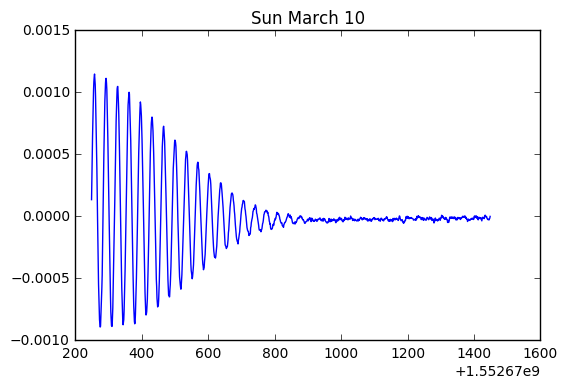

In [45]:
plt.plot(sun_10_time, sun_10_volts)
plt.title('Sun March 10')
plt.show()

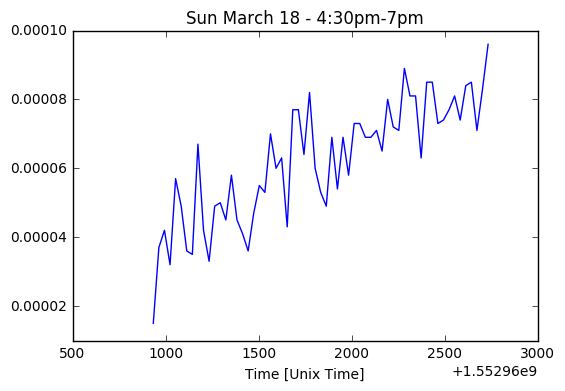

In [77]:
plt.plot(sun_18_time[0], sun_18_volts[0])
plt.title('Sun March 18 - 4:30pm-7pm')
plt.xlabel('Time [Unix Time]')
plt.show()

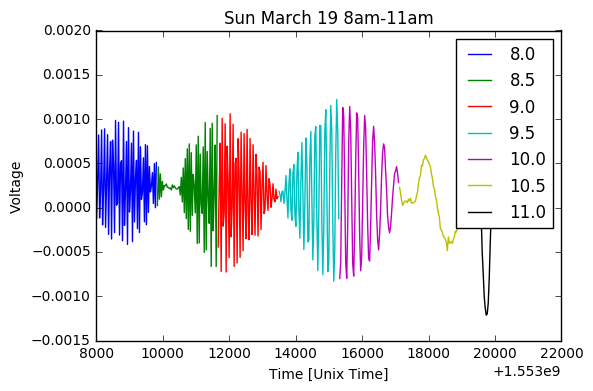

In [79]:
for i in range(len(sun_19_volts)):
    plt.plot(sun_19_time[i], sun_19_volts[i], label = i*0.5 + 8)
plt.title('Sun March 19 8am-11am')
plt.xlabel('Time [Unix Time]')
plt.ylabel('Voltage')
plt.legend()
plt.show()

(37.89323171038123, 'seconds')


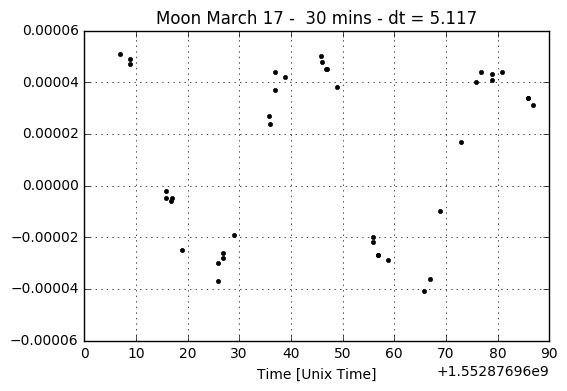

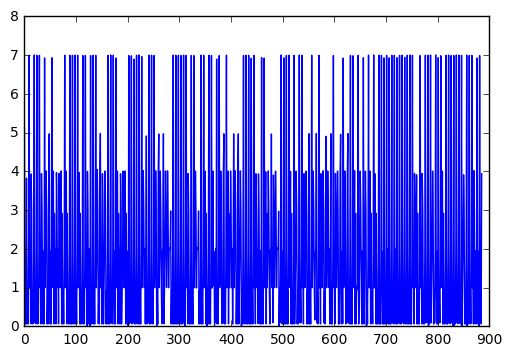

In [126]:
import ugradio

jd = ugradio.timing.julian_date(moon_17_time[0][220])
ra, dec = ugradio.coord.moonpos(jd)

lst = 180*ugradio.timing.lst(jd)/np.pi
ha = ra-lst
lam = 2.8 #cm
bx = 1500 #vary this ~50ft in cm

f = bx/lam * np.cos(np.deg2rad(dec)) * np.sin(np.deg2rad(ha)) * 2*np.pi/ 86164
print(1/f , 'seconds')


plt.plot(moon_17_time[0][200:240], moon_17_volts[0][200:240], 'k.')
plt.title('Moon March 17 -  30 mins - dt = 5.117')
plt.xlabel('Time [Unix Time]')
plt.grid()
#plt.xlim(200,240)
plt.show()

dt = moon_17_time[0][1:] - moon_17_time[0][0:-1]
#print(dt)

plt.plot(dt)
plt.show()

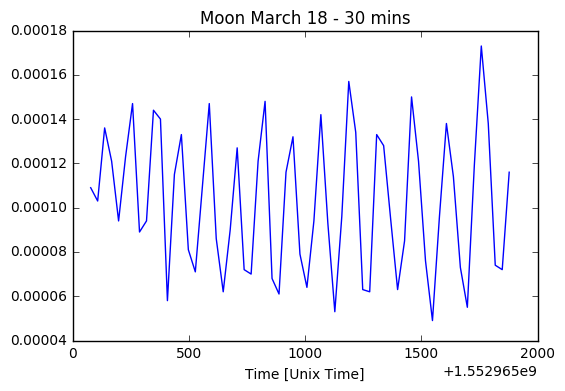

In [69]:
plt.plot(moon_18_time[0], moon_18_volts[0])
plt.title('Moon March 18 - 30 mins')
plt.xlabel('Time [Unix Time]')
plt.show()

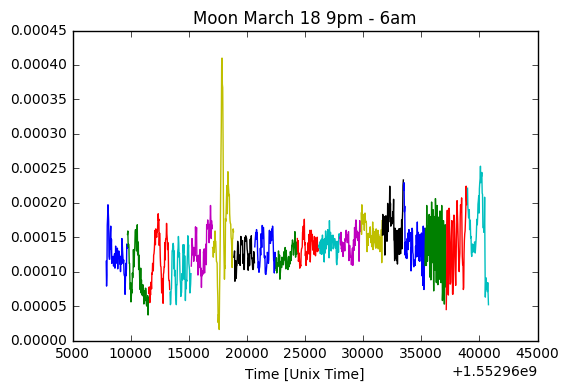

In [76]:
for i in range(len(moon_18_2_volts)):

    plt.plot(moon_18_2_time[i], moon_18_2_volts[i], label = i*0.5+9)
plt.title('Moon March 18 9pm - 6am')
plt.xlabel('Time [Unix Time]')

plt.show()

In [80]:
import powerspectrum

In [129]:
hpm = ugradio.hp_multi.HP_Multimeter()

In [131]:
import time
hpm.start_recording(dt = 10)
time.sleep(30)
hpm.end_recording()
tempData, tempTime = hpm.get_recording_data()
print tempData

[ 0.000728  0.000734  0.000727  0.000727]


In [132]:
hpm.start_recording(dt = 10, tries = 2)
time.sleep(30)
hpm.end_recording()
tempData, tempTime = hpm.get_recording_data()
print tempData

[ 0.000722  0.000728  0.000728  0.000742]
